In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt


import pandas as pd
from sklearn.preprocessing import OneHotEncoder


# STEP 4: Payment of employees


- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

<hr/>

In [32]:
df_train = pd.read_csv('./Data/step3/df_train.csv')
df_test = pd.read_csv('./Data/step3/df_test.csv')
df_submission = pd.read_csv('./Data/step3/df_submission.csv')

df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_submission['date'] = pd.to_datetime(df_submission['date'])

In [41]:
transactions = pd.read_csv('./Data/kaggle/transactions.csv')

transactions['date'] = pd.to_datetime(transactions['date'])

### Feature Engineering and Analysis

#### Checking Payment days

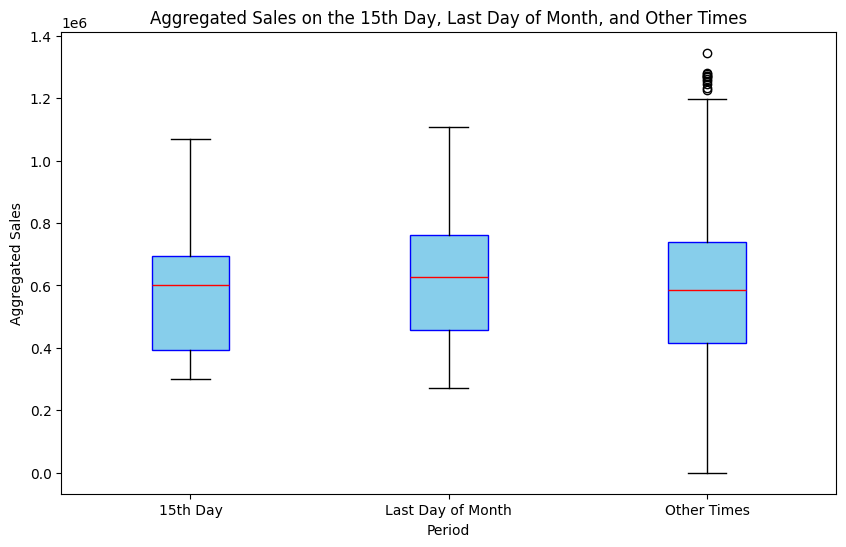

In [30]:
from scipy.stats import ks_2samp, ttest_ind

# Aggregate sales by date (sum sales for all stores for each day)
aggregated_sales = df_train.groupby('date')['sales'].sum().reset_index()

# Create indicators for the 15th day and the last day of the month
aggregated_sales['is_15th'] = aggregated_sales['date'].dt.day == 15
aggregated_sales['is_last_day'] = aggregated_sales['date'].dt.is_month_end

# Separate sales data into different periods
sales_15th = aggregated_sales[aggregated_sales['is_15th']]['sales']
sales_last_day = aggregated_sales[aggregated_sales['is_last_day']]['sales']
sales_other = aggregated_sales[~aggregated_sales['is_15th'] & ~aggregated_sales['is_last_day']]['sales']
# Data for plotting
data = [sales_15th, sales_last_day, sales_other]
labels = ['15th Day', 'Last Day of Month', 'Other Times']

# Plot the data
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='blue'), 
            medianprops=dict(color='red'))
plt.xlabel('Period')
plt.ylabel('Aggregated Sales')
plt.title('Aggregated Sales on the 15th Day, Last Day of Month, and Other Times')
plt.show()

#### Add Pay days Features

In [33]:
df_train.loc[df_train['date'].dt.day == 15, 'first_pay_day'] = 1
df_train['first_pay_day'] = df_train['first_pay_day'].fillna(0)

df_test.loc[df_test['date'].dt.day == 15, 'first_pay_day'] = 1
df_test['first_pay_day'] = df_test['first_pay_day'].fillna(0)

df_submission.loc[df_submission['date'].dt.day == 15, 'first_pay_day'] = 1
df_submission['first_pay_day'] = df_submission['first_pay_day'].fillna(0)

- Add First Pay day

In [34]:
df_train.loc[(df_train['date'].dt.is_month_end), 'second_pay_day'] = 1
df_train['second_pay_day'] = df_train['second_pay_day'].fillna(0)

df_test.loc[(df_test['date'].dt.is_month_end), 'second_pay_day'] = 1
df_test['second_pay_day'] = df_test['second_pay_day'].fillna(0)

df_submission.loc[(df_submission['date'].dt.is_month_end), 'second_pay_day'] = 1
df_submission['second_pay_day'] = df_submission['second_pay_day'].fillna(0)

- Add Second pay day

### Encode and Generate Sets

In [47]:
train_cols = ['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store']

holiday_cols = ['is_National_holiday', 'day_after_national_holiday',
       'day_before_national_holiday', 'is_Local_holiday',
       'is_Regional_holiday', 'is_Local_holiday_real',
       'is_Regional_holiday_real']

oil_cols = ['dcoilwtico']

pay_cols = ['first_pay_day', 'second_pay_day']

In [61]:
X_train_1, y_train = df_train[train_cols + holiday_cols + oil_cols + pay_cols], df_train['sales']
X_test_1, y_test = df_test[train_cols + holiday_cols + oil_cols + pay_cols], df_test['sales']
X_submission_1 = df_submission[train_cols + holiday_cols + oil_cols + pay_cols + ['id']]

- Set with all columns

In [62]:
X_train_2, y_train = df_train[train_cols + holiday_cols + pay_cols], df_train['sales']
X_test_2, y_test = df_test[train_cols + holiday_cols + pay_cols], df_test['sales']
X_submission_2 = df_submission[train_cols + holiday_cols + pay_cols + ['id']]

- Set with train columns, holiday columns and pay day columns

In [63]:
X_train_3, y_train = df_train[train_cols + oil_cols + pay_cols], df_train['sales']
X_test_3, y_test = df_test[train_cols + oil_cols + pay_cols], df_test['sales']
X_submission_3 = df_submission[train_cols + oil_cols + pay_cols + ['id']]

- Set with train columns, oil price columns and pay day columns

In [64]:
X_train_4, y_train = df_train[train_cols + pay_cols], df_train['sales']
X_test_4, y_test = df_test[train_cols + pay_cols], df_test['sales']
X_submission_4 = df_submission[train_cols + pay_cols + ['id']]

- Set with train columns and pay day columns

In [52]:

def encode_one_how(X_train, X_test, X_submission, categorical_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train[categorical_cols])

    # Transform the training and test data
    train_encoded_array = encoder.transform(X_train[categorical_cols])
    test_encoded_array = encoder.transform(X_test[categorical_cols])
    submission_encoded_array = encoder.transform(X_submission[categorical_cols])
    

    # Create DataFrames with the encoded data
    train_encoded_df = pd.DataFrame(train_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    test_encoded_df = pd.DataFrame(test_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
    submission_encoded_df = pd.DataFrame(submission_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_submission.index)
    

    # Concatenate the original DataFrame (excluding the original categorical columns) with the encoded DataFrame
    X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols), train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols), test_encoded_df], axis=1)
    X_submission_encoded = pd.concat([X_submission.drop(columns=categorical_cols), submission_encoded_df], axis=1)
    
    return X_train_encoded, X_test_encoded, X_submission_encoded
        

In [65]:
X_train_1, X_test_1, X_submission_1 = encode_one_how(X_train_1, X_test_1, X_submission_1, ['family', 'month', 'day_of_week'])

In [66]:
X_train_2, X_test_2, X_submission_2 = encode_one_how(X_train_2, X_test_2, X_submission_2, ['family', 'month', 'day_of_week'])


In [67]:
X_train_3, X_test_3, X_submission_3 = encode_one_how(X_train_3, X_test_3, X_submission_3, ['family', 'month', 'day_of_week'])


In [68]:
X_train_4, X_test_4, X_submission_4 = encode_one_how(X_train_4, X_test_4, X_submission_4, ['family', 'month', 'day_of_week'])


In [69]:
X_train_1.shape, X_test_1.shape, X_submission_1.shape

((2603502, 67), (404514, 67), (28512, 68))

In [70]:
X_train_2.shape, X_test_2.shape, X_submission_2.shape

((2603502, 66), (404514, 66), (28512, 67))

In [71]:
X_train_3.shape, X_test_3.shape, X_submission_3.shape

((2603502, 60), (404514, 60), (28512, 61))

In [72]:
X_train_4.shape, X_test_4.shape, X_submission_4.shape

((2603502, 59), (404514, 59), (28512, 60))

### Models Evaluation

In [73]:
# Train and evaluate model for each store
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)



#### Compare Models and Training Sets - One Store Prediction

In [74]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': GradientBoostingRegressor(random_state=42)
}

sets = {
    'Train With Oil Prince, Holidays and Pay days': [
        X_train_1[X_train_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_1['store_nbr'] == 10], 
        X_test_1[X_test_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_1['store_nbr'] == 10]
    ],
    'Train With Holidays and Pay days': [
        X_train_2[X_train_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_2['store_nbr'] == 10], 
        X_test_2[X_test_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_2['store_nbr'] == 10]
    ],
    'Train With Oil Prince and Pay days': [
        X_train_2[X_train_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_2['store_nbr'] == 10], 
        X_test_2[X_test_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_2['store_nbr'] == 10]
    ],
          'Train With Pay days': [
        X_train_2[X_train_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_2['store_nbr'] == 10], 
        X_test_2[X_test_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_2['store_nbr'] == 10]
    ],
    
}
def evaluate_models(models, sets):
    results = []

    for set_name, data in sets.items():
        X_train, y_train, X_test, y_test = data
        
        for model_name, model in models.items():
            # Train the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            y_pred[y_pred < 0] = 0
            # Calculate Mean Squared Error
            score = rmsle(y_test, y_pred)
            
            # Append results
            results.append({
                'Set': set_name,
                'Model': model_name,
                'RMSLE': score
            })
    return pd.DataFrame(results)

In [75]:
results = evaluate_models(models, sets)
results

,Set,Model,RMSLE
0,"Train With Oil Prince, Holidays and Pay days",RandomForest,0.569976
1,"Train With Oil Prince, Holidays and Pay days",XGBoost,1.681077
2,Train With Holidays and Pay days,RandomForest,0.574506
3,Train With Holidays and Pay days,XGBoost,1.680999
4,Train With Oil Prince and Pay days,RandomForest,0.574506
5,Train With Oil Prince and Pay days,XGBoost,1.680999
6,Train With Pay days,RandomForest,0.574506
7,Train With Pay days,XGBoost,1.680999


In [76]:
results.to_csv('./Data/step4/results.csv')

- Results got worst with addition of oil price, when compared to step1 results

#### Train for all Stores 

In [77]:


def train_per_store(stores, X_train, y_train, X_test, y_test):
    all_y_true = []
    all_y_pred_rf = []
    models = {}

    for store_nbr in stores:
        print('Store', store_nbr)
        X_train_st = X_train[X_train['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        X_test_st = X_test[X_test['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        
        y_train_st = y_train[X_train['store_nbr'] == store_nbr]
        y_test_st = y_test[X_test['store_nbr'] == store_nbr]
        
        # Train Random Forest Regressor
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train_st, y_train_st) 
        # Make predictions
        y_pred_rf = rf.predict(X_test_st)
        # Append true values and predictions to the lists
        all_y_true.extend(y_test_st)
        all_y_pred_rf.extend(y_pred_rf)
        
        
        models[store_nbr] = {
            'rf': rf
        }
    
    total_rmsle_rf = rmsle(np.array(all_y_true), np.array(all_y_pred_rf))

    return {
        'Random Forest': total_rmsle_rf,
        'models': models
    }
        
def predict_per_store(models, X_submission, model_name='rf'):
    stores = X_submission['store_nbr'].unique()
    predictions = {'id': [], 'sales': []}
    for store in stores:
        X_submission_st = X_submission[X_submission['store_nbr'] == store]
        ids = X_submission_st['id']
        X_submission_st = X_submission_st.drop(columns=['id', 'store_nbr'])
        y_pred = models[store][model_name].predict(X_submission_st)

        predictions['id'] += list(ids)
        predictions['sales'] += list(y_pred)
        
    predictions_df = pd.DataFrame(predictions)
    return predictions_df
        


In [78]:
stores = df_train['store_nbr'].unique()
result = train_per_store(stores, X_train_1, y_train, X_test_1, y_test)
print('RMLSE with One hot', result['Random Forest'])

Store 1


In [ ]:
forth_submission_df = predict_per_store(result['models'], X_submission_1)
forth_submission_df.to_csv('./Data/submssions/submission_step4.csv', index=False)

In [ ]:
# Train and evaluate model for each store
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)



#### Compare Models and Training Sets - One Store Prediction

In [ ]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': GradientBoostingRegressor(random_state=42)
}

sets = {
    'Train With Oil Prince': [
        X_train_1[X_train_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_1['store_nbr'] == 10], 
        X_test_1[X_test_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_1['store_nbr'] == 10]
    ],
    'Train With Oil Prince and Holiday Info': [
        X_train_2[X_train_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_2['store_nbr'] == 10], 
        X_test_2[X_test_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_2['store_nbr'] == 10]
    ],
    
}
def evaluate_models(models, sets):
    results = []

    for set_name, data in sets.items():
        X_train, y_train, X_test, y_test = data
        
        for model_name, model in models.items():
            # Train the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            y_pred[y_pred < 0] = 0
            # Calculate Mean Squared Error
            score = rmsle(y_test, y_pred)
            
            # Append results
            results.append({
                'Set': set_name,
                'Model': model_name,
                'RMSLE': score
            })
    return pd.DataFrame(results)

In [ ]:
results = evaluate_models(models, sets)
results

,Set,Model,RMSLE
0,Train With Oil Prince,RandomForest,0.573412
1,Train With Oil Prince,XGBoost,1.681070
2,Train With Oil Prince and Holiday Info,RandomForest,0.575190
3,Train With Oil Prince and Holiday Info,XGBoost,1.681069


In [ ]:
results.to_csv('./Data/step3/results.csv')

- Results got worst with addition of oil price, when compared to step1 results

#### Train for all Stores 

In [ ]:


def train_per_store(stores, X_train, y_train, X_test, y_test):
    all_y_true = []
    all_y_pred_rf = []
    models = {}

    for store_nbr in stores:
        print('Store', store_nbr)
        X_train_st = X_train[X_train['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        X_test_st = X_test[X_test['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        
        y_train_st = y_train[X_train['store_nbr'] == store_nbr]
        y_test_st = y_test[X_test['store_nbr'] == store_nbr]
        
        # Train Random Forest Regressor
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train_st, y_train_st) 
        # Make predictions
        y_pred_rf = rf.predict(X_test_st)
        # Append true values and predictions to the lists
        all_y_true.extend(y_test_st)
        all_y_pred_rf.extend(y_pred_rf)
        
        
        models[store_nbr] = {
            'rf': rf
        }
    
    total_rmsle_rf = rmsle(np.array(all_y_true), np.array(all_y_pred_rf))

    return {
        'Random Forest': total_rmsle_rf,
        'models': models
    }
        
def predict_per_store(models, X_submission, model_name='rf'):
    stores = X_submission['store_nbr'].unique()
    predictions = {'id': [], 'sales': []}
    for store in stores:
        X_submission_st = X_submission[X_submission['store_nbr'] == store]
        ids = X_submission_st['id']
        X_submission_st = X_submission_st.drop(columns=['id', 'store_nbr'])
        y_pred = models[store][model_name].predict(X_submission_st)

        predictions['id'] += list(ids)
        predictions['sales'] += list(y_pred)
        
    predictions_df = pd.DataFrame(predictions)
    return predictions_df
        


In [ ]:
stores = df_train['store_nbr'].unique()
result = train_per_store(stores, X_train_1, y_train, X_test_1, y_test)
print('RMLSE with One hot', result['Random Forest'])

Store 1
Store 10
Store 11
Store 12
Store 13
Store 14
Store 15
Store 16
Store 17
Store 18
Store 19
Store 2
Store 20
Store 21
Store 22
Store 23
Store 24
Store 25
Store 26
Store 27
Store 28
Store 29
Store 3
Store 30
Store 31
Store 32
Store 33
Store 34
Store 35
Store 36
Store 37
Store 38
Store 39
Store 4
Store 40
Store 41
Store 42
Store 43
Store 44
Store 45
Store 46
Store 47
Store 48
Store 49
Store 5
Store 50
Store 51
Store 52
Store 53
Store 54
Store 6
Store 7
Store 8
Store 9
RMLSE with One hot 0.7515214487220195


In [ ]:
third_submission_df = predict_per_store(result['models'], X_submission_1)
third_submission_df.to_csv('./Data/submssions/submission_step3.csv', index=False)